In [132]:
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

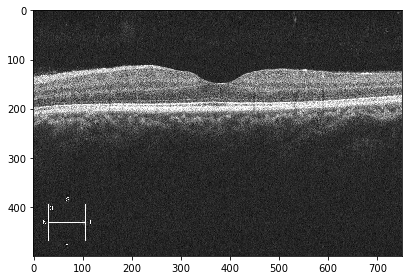

In [133]:
X = imread("NORMAL1.jpeg")
#Taking the first of the 3 channels, as they are all the same.
X = X[:,:,0]
h, w = X.shape
imshow(X)

In [134]:
compression_factor = 3
mask = np.zeros((h,w))
mask[:,np.arange(0, w, compression_factor)] = 1
D = X*mask
# plt.imshow(X_, cmap="gray")

In [135]:
B1, S, B2t = np.linalg.svd(D, full_matrices=True)
A = np.zeros_like(D)
W = np.zeros_like(D)
np.fill_diagonal(W, S)
E = np.zeros_like(D)
Y1= np.zeros_like(D)
Y2 = np.zeros_like(W)
nu1 = 3
nu2 = 3
mu = 1
lmda = 0.001
a = 0.85
ro = 1.05
# plt.imshow(B1 @ W @ B2t, cmap="gray")


In [136]:
def SoftThresh(x, tau):
    # numpy automatically applies functions to each element of the array
    return np.sign(x)*np.maximum(0, np.abs(x) - tau)

def ShrinkageOperator(X, tau):
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S = np.diag(SoftThresh(S,tau))
    return U @ S @ Vt

def Proj(X, mask):
    return X*mask

def AUpdate(W, Y1, mu):
    Z = W - (1/mu)*Y1
    return ShrinkageOperator(Z, 1/mu)

def WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda):
    Z = B1 @ W @ B2t + E - D + (1/mu)*Y2
    Z = Proj(Z, mask)
    Z = B1.T @ Z @ B2t.T + W - A - (1/mu)*Y1
    Z = W - (1/nu1)*Z
    return SoftThresh(Z, lmda/(nu1*mu))

def EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a):
    Z = E + B1 @ W @ B2t - D
    Z = Proj(Z, mask) + (1/mu)*Y2
    Z =  E - (1/nu2)*Z
    return SoftThresh(Z, a/(mu*nu2))

def Y1Update(mask, W, E, D, B1, B2t, Y1, mu):
    Z = B1 @ W @ B2t + E - D
    return Y1 + mu*Proj(Z, mask)

def Y2Update(A, W, Y2, mu):
    return Y2 + mu*(A - W)

def muUpdate(mu, ro):
    return mu*ro


In [137]:
iters = 10
for i in range(iters):
    A = AUpdate(W, Y1, mu)
    W = WUpdate(mask, A, W, E, D, B1, B2t, Y1, Y2, mu, nu1, lmda)
    E = EUpdate(mask, W, E, D, B1, B2t, Y2, mu, nu2, a)
    Y1 = Y1Update(mask, W, E, D, B1, B2t, Y1, mu)
    Y2 = Y2Update(A, W, Y2, mu)
    mu = muUpdate(mu, ro)

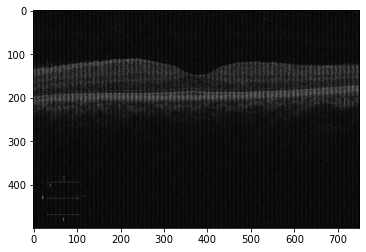

In [138]:
plt.imshow(B1 @ W @ B2t, cmap="gray")